# Relax Inc. Challenge

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [2]:
# 12,000 users who signed up for the product in the last two years.
df_users = pd.read_csv("./takehome_users.csv")
df_users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [3]:
# Usage summary table  that has a row for each day that a user logged into the product.
df_engagement = pd.read_csv("./takehome_user_engagement.csv")
df_engagement.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


## Clean and Explore Data

In [4]:
# Inspect users
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
# Counts of null values 
df_users.isna().sum().sort_values(ascending=False)

invited_by_user_id            5583
last_session_creation_time    3177
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
dtype: int64

In [6]:
# Inspect engagement
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# Counts of null values 
df_engagement.isna().sum().sort_values(ascending=False)

time_stamp    0
user_id       0
visited       0
dtype: int64

In [8]:
# Defining an "adopted user" as a user who  has logged into the product on three separate days in at least one seven day period.
# Get data in helpful format for date analysis.
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'])
df_engagement = df_engagement.set_index('time_stamp')
# Group by user and count total logins per week.
df_engagement = df_engagement.groupby(by='user_id').resample('1W').sum()
# user_id is now duplicated (is the index and a column).
df_engagement.drop('user_id', axis=1, inplace=True)
df_engagement.head(25)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1
        2014-01-19        0
        2014-01-26        0
        2014-02-02        0
        2014-02-09        3
        2014-02-16        2
        2014-02-23        0
        2014-03-02        0
        2014-03-09        1
        2014-03-16        1
        2014-03-23        0
        2014-03-30        0
        2014-04-06        1
3       2013-03-24        1
4       2013-05-26        1
5       2013-01-27        1

In [9]:
df_adopted = df_engagement[df_engagement['visited'] >= 3]
df_adopted.head()

visited
user_id time_stamp         
2       2014-02-09        3
10      2013-03-03        3
        2013-04-14        3
        2013-04-28        3
        2013-05-05        4

In [10]:
# Get the unique user ids in the MultiIndex.
adopted_user_id = list(df_adopted.index.unique(level=0))
len(adopted_user_id)

1445

There are 1,445 out of 12,000 users that meet the adopted criteria for this project.

Note: Originally, I attempted to merge the dataframes first on an inner join and then do the analysis above.
However, this was a mistake because it made the combined dataframe much larger with a lot of duplicate data.
Also, this would have introduced data leakage because the features in the engagement file should not be used in the model evaluation later.

In [11]:
# Now, it is time to add the target feature (if the user is an adopted user or not) to the users dataframe.
df_users['is_adopted'] = np.where(df_users.object_id.isin(adopted_user_id), 1, 0)
# Expect new column to total 1,445. There will be an error if this isn't the case.
assert(df_users.is_adopted.sum() == 1445)
df_users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0


Earlier we determined some data was missing:  
- invited_by_user_id:            5583
- last_session_creation_time:    3177

Will set missing values for invited_by_user_id means to -1 because assuming this means the user created the account without a referral. 
Then, will set last_session_creation_time to 0 because assuming this means the user is currently inactive because they either: 
- created the account and then never logged in.
- had a last login that was before the time period of this project's data.

Would also potentially review these assumptions with someone on my team on a real project if I was unsure what the preferred process was.

In [12]:
df_users.invited_by_user_id.fillna(-1, inplace=True)
df_users.last_session_creation_time.fillna(0, inplace=True)
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  is_adopted                  12000 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 984.5+ KB


In [13]:
# Remove possibly sensitive data
# Create a column with just the domain name for the email address.
df_users['domain'] = [x.split('@')[1] for x in df_users['email']]
# Find common_domains
df_users.domain.value_counts().loc[lambda x: x > 1000]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
Name: domain, dtype: int64

In [14]:
# Set all non-common domains to 'other'.
common_domains = sorted(['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com'])
df_users['domain'] = np.where(df_users.domain.isin(common_domains), df_users.domain, 'other')
df_users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted,domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,gustr.com


In [15]:
# Assuming names are sensitive.
# Therefore, need to drop name and email columns.
df_users.drop(columns=['name', 'email'], axis=1, inplace=True)

In [16]:
# Change the index to use the user's id.
df_users.set_index('object_id', inplace=True)

In [17]:
# Fix the date time and numeric data types as needed.
df_users.creation_time = pd.to_datetime(df_users.creation_time)
df_users.last_session_creation_time = pd.to_datetime(df_users.last_session_creation_time)
df_users.opted_in_to_mailing_list = df_users['opted_in_to_mailing_list'].astype('bool')
df_users.enabled_for_marketing_drip = df_users['enabled_for_marketing_drip'].astype('bool')
df_users.is_adopted = df_users['is_adopted'].astype('bool')
df_users.invited_by_user_id = df_users['invited_by_user_id'].astype('int64')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  12000 non-null  datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  bool          
 4   enabled_for_marketing_drip  12000 non-null  bool          
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          12000 non-null  int64         
 7   is_adopted                  12000 non-null  bool          
 8   domain                      12000 non-null  object        
dtypes: bool(3), datetime64[ns](2), int64(2), object(2)
memory usage: 691.4+ KB


In [18]:
# The remaining statistics here aren't helpful.
df_users.describe()

,org_id,invited_by_user_id
count,12000.000000,12000.000000
mean,141.884583,3188.226083
std,124.056723,3869.411178
min,0.000000,-1.000000
25%,29.000000,-1.000000
50%,108.000000,875.000000
75%,238.250000,6317.000000
max,416.000000,11999.000000


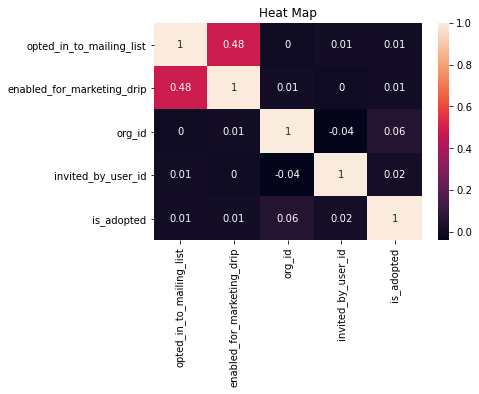

In [19]:
# Check for correlation.
sns.heatmap(round(df_users.corr(), 2), annot=True)
plt.title('Heat Map')
plt.show()

In [20]:
# Check for categories
df_users.nunique()

creation_time                 11996
creation_source                   5
last_session_creation_time     8822
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2565
is_adopted                        2
domain                            7
dtype: int64

In [21]:
df_users.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [22]:
# Analyzing to determine if the org_id should be grouped by size.
# Don't see a clear pattern here.
df_users['org_id'].value_counts(bins=[0, 20, 50, 100, 250, 500])

(100.0, 250.0]    3453
(250.0, 500.0]    2765
(-0.001, 20.0]    2503
(50.0, 100.0]     1771
(20.0, 50.0]      1508
Name: org_id, dtype: int64

In [23]:
# One hot encode the categories.
df_cleaned = pd.get_dummies(df_users, prefix=['source', 'org_id', 'domain'], columns=['creation_source', 'org_id', 'domain'])
df_cleaned.head(3)

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,is_adopted,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,...,org_id_414,org_id_415,org_id_416,domain_cuvox.de,domain_gmail.com,domain_gustr.com,domain_hotmail.com,domain_jourrapide.com,domain_other,domain_yahoo.com
object_id,,,,,,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,1970-01-01 00:00:01.398138810,True,False,10803,False,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2013-11-15 03:45:04,1970-01-01 00:00:01.396237504,False,False,316,True,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2013-03-19 23:14:52,1970-01-01 00:00:01.363734892,False,False,1525,False,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


## Preprocess and Train

## Evaluate Models

## Summary